In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-janatahack-crosssell-prediction/sample_submission_iA3afxn.csv
/kaggle/input/av-janatahack-crosssell-prediction/test.csv
/kaggle/input/av-janatahack-crosssell-prediction/train.csv


# Libraries

In [71]:
import time

# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special, stats

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score


# SMOTe
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score, precision_recall_curve 
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc, plot_confusion_matrix

# ensemble
from xgboost import XGBClassifier

# warnings
import warnings
warnings.filterwarnings("ignore")

# style
import matplotlib.style as style
style.use('fivethirtyeight')

# Reading Data

In [4]:
train_path = '/kaggle/input/av-janatahack-crosssell-prediction/train.csv'
test_path = '/kaggle/input/av-janatahack-crosssell-prediction/test.csv'

In [5]:
train_df = pd.read_csv(train_path)
print("Train df size", train_df.shape)
train_df.head()

Train df size (381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
test_df = pd.read_csv(test_path)
print("Test df size", test_df.shape)
test_df.head()

Test df size (127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [7]:
# Check for null values if any

# This method shows the count of null values, percent and dataTypes

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
        
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
missing_data(train_df)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Total,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,int64,int64,float64,int64,object,object,float64,float64,int64,int64


In [9]:
missing_data(test_df)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
Total,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,int64,int64,float64,int64,object,object,float64,float64,int64


In [10]:
# print("Train Test distribution 100 :", test_df.shape[0] * 100 // train_df.shape[0])

# Data Dictionary

| Variable             | Definition                                                                                                                  |
|----------------------|-----------------------------------------------------------------------------------------------------------------------------|
| id                   | Unique ID for the customer                                                                                                  |
| Gender               | Gender of the customer                                                                                                      |
| Age                  | Age of the customer                                                                                                         |
| Driving_License      | 0 : Customer does not have DL, 1 : Customer already has DL                                                                  |
| Region_Code          | Unique code for the region of the customer                                                                                  |
| Previously_Insured   | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance                                     |
| Vehicle_Age          | Age of the Vehicle                                                                                                          |
| Vehicle_Damage       | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.          |
| Annual_Premium       | The amount customer needs to pay as premium in the year                                                                     |
| Policy_Sales_Channel | Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. |
| Vintage              | Number of Days, Customer has been associated with the company                                                               |
| Response             | 1 :  Customer is interested, 0 : Customer is not interested                                                                 |

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# Checking for imbalance in Target Variable

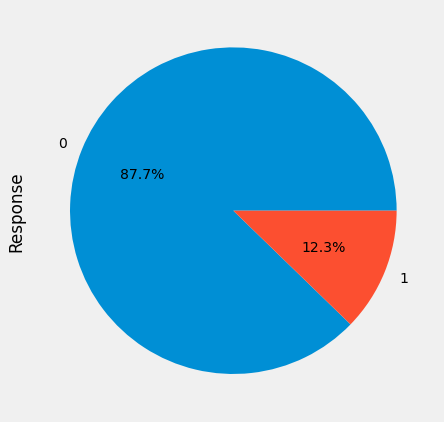

In [12]:
def plot_pie(dataset, target, size=(7,7)):
    return dataset[target].value_counts().plot.pie(autopct = '%1.1f%%', figsize=size)

plot_pie(train_df, 'Response')

# 1.Gender

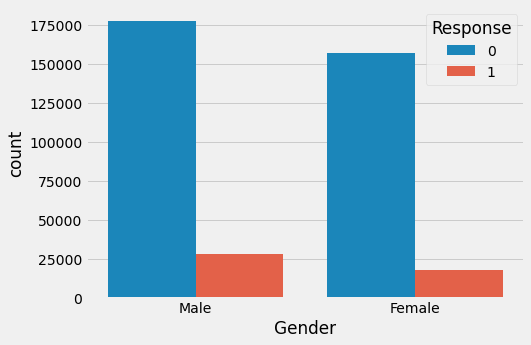

In [13]:
def countplot(dataset, x, y, size=(7,5), is_x_large=False):
    plt.figure(figsize=size)
    if is_x_large: 
        plt.xticks(fontsize=16)
    return sns.countplot(dataset[x], hue = dataset[y])

countplot(train_df, x='Gender', y='Response')


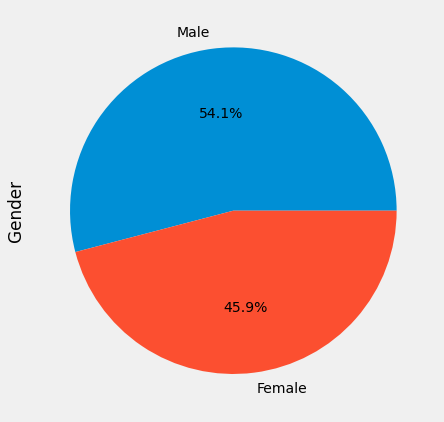

In [14]:
plot_pie(train_df, 'Gender')

# 2. Age

(<matplotlib.axes._subplots.AxesSubplot at 0x7f438032a1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43802e3150>)

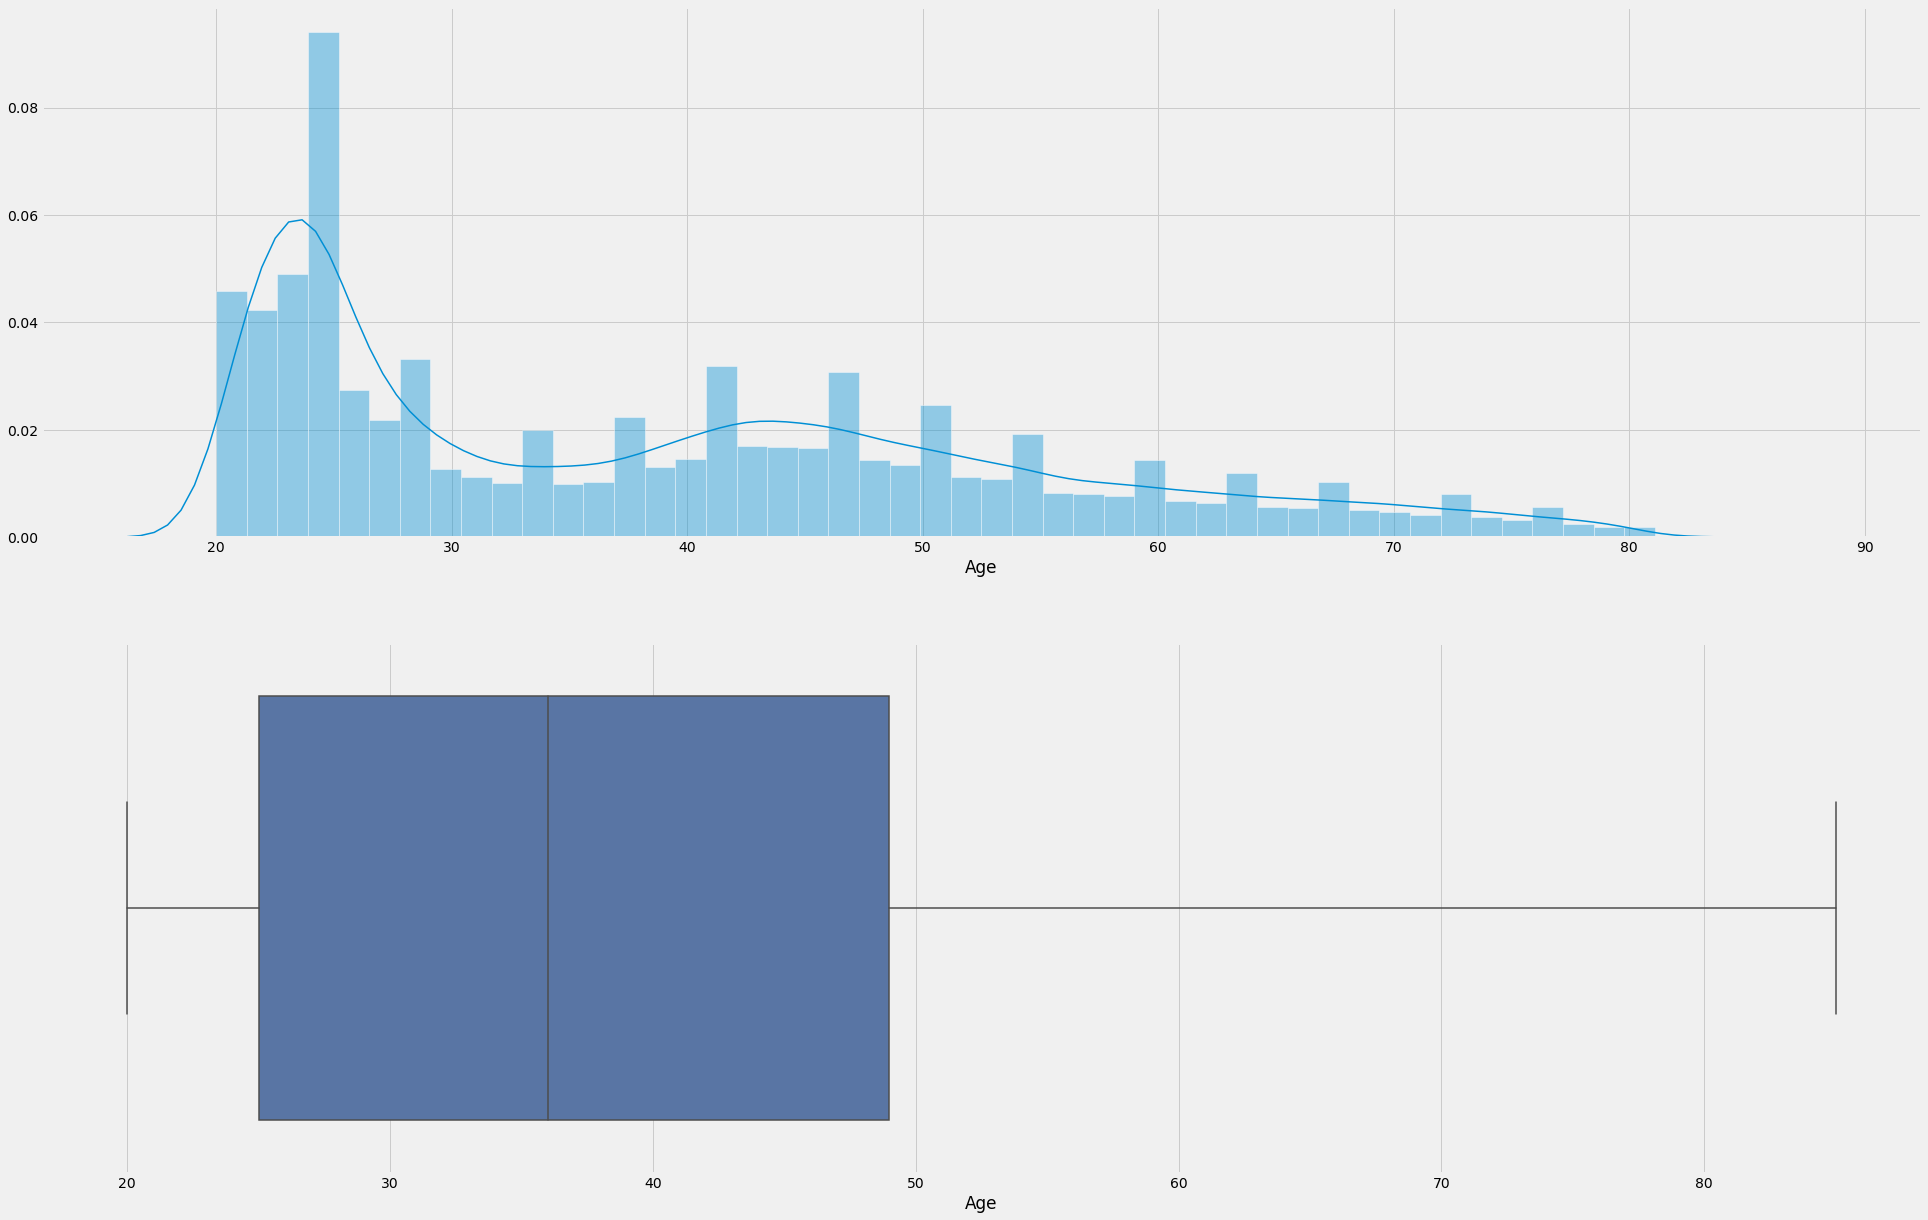

In [15]:
def dist_and_box_plots(dataset, feature, size=(30,20)):
    f,ax = plt.subplots(nrows=2,ncols=1,figsize=size)
    axx = ax.flatten()
    sns.set(font_scale=1)  # 5=crazy big
    plt1 = sns.distplot(dataset[feature],ax=axx[0])
    plt2 = sns.boxplot(dataset[feature],ax=axx[1])
    return plt1, plt2 

dist_and_box_plots(dataset=train_df, feature='Age')

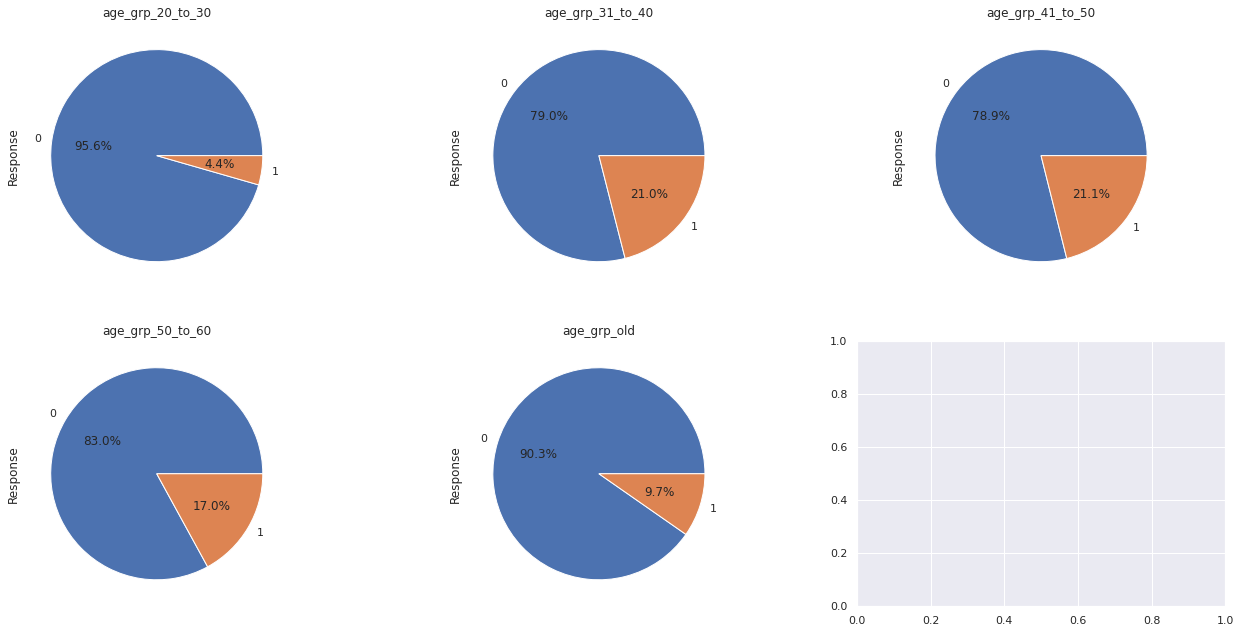

In [16]:
# binning into age groups and making a dictionary based on groups
age_grp_20_to_30 = train_df[ train_df['Age'] <31]
age_grp_31_to_40 = train_df[ train_df['Age'].between(31,40)]
age_grp_41_to_50 = train_df[ train_df['Age'].between(41,50)]
age_grp_50_to_60 = train_df[ train_df['Age'].between(51,60)]
age_grp_old = train_df[ train_df['Age'] >60]

age_grp = [age_grp_20_to_30,age_grp_31_to_40,age_grp_41_to_50,age_grp_50_to_60,age_grp_old]
age_grp_name = ['age_grp_20_to_30','age_grp_31_to_40','age_grp_41_to_50','age_grp_50_to_60','age_grp_old']
age_grp_dict = dict(zip(age_grp_name, age_grp))

# 5 groups so matrix size is 6 [2x3]
f,ax = plt.subplots(nrows=2, ncols=3, figsize = (20,10))
axx = ax.flatten()
for pos,tup in enumerate(age_grp_dict.items()):
    axx[pos].set_title(tup[0])
    data = tup[1]
    data['Response'].value_counts().plot.pie(autopct='%1.1f%%', ax = axx[pos])

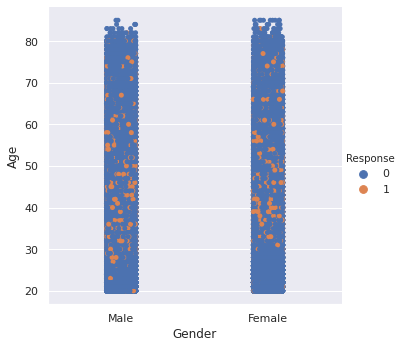

In [17]:
sns.catplot(x='Gender', y="Age", hue = 'Response', data=train_df)

# 3. Driving License

(<matplotlib.axes._subplots.AxesSubplot at 0x7f43629538d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4380050a50>)

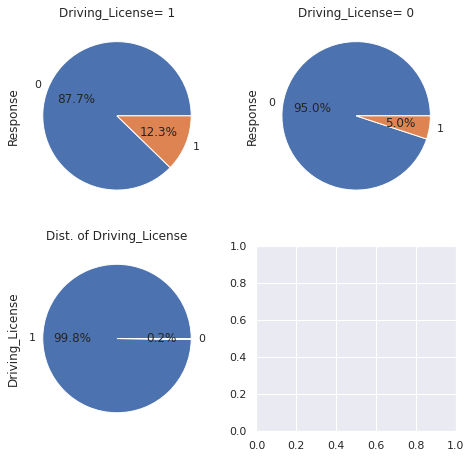

In [18]:
def bivariate_pie_charts(dataset, x, y, size=(7,7)):
    f,ax = plt.subplots(nrows=2,ncols=2,figsize=size)
    axx = ax.flatten()
    #plt.title('Driving_License wise Response',fontsize=40,x=-0.5,y=2)
    axx[0].set_title(x + '= 1')
    axx[1].set_title(x + '= 0')
    axx[2].set_title('Dist. of ' + x)
    plt1 = dataset[dataset[x] == 1][y].value_counts().plot.pie(autopct='%1.1f%%',ax=axx[0])
    plt2 = dataset[dataset[x] == 0][y].value_counts().plot.pie(autopct='%1.1f%%',ax=axx[1])
    plt3 = dataset[x].value_counts().plot.pie(autopct='%1.1f%%',ax=axx[2])
    return plt1, plt2, plt3

bivariate_pie_charts(dataset=train_df, x='Driving_License', y='Response')

# 4. Region Code

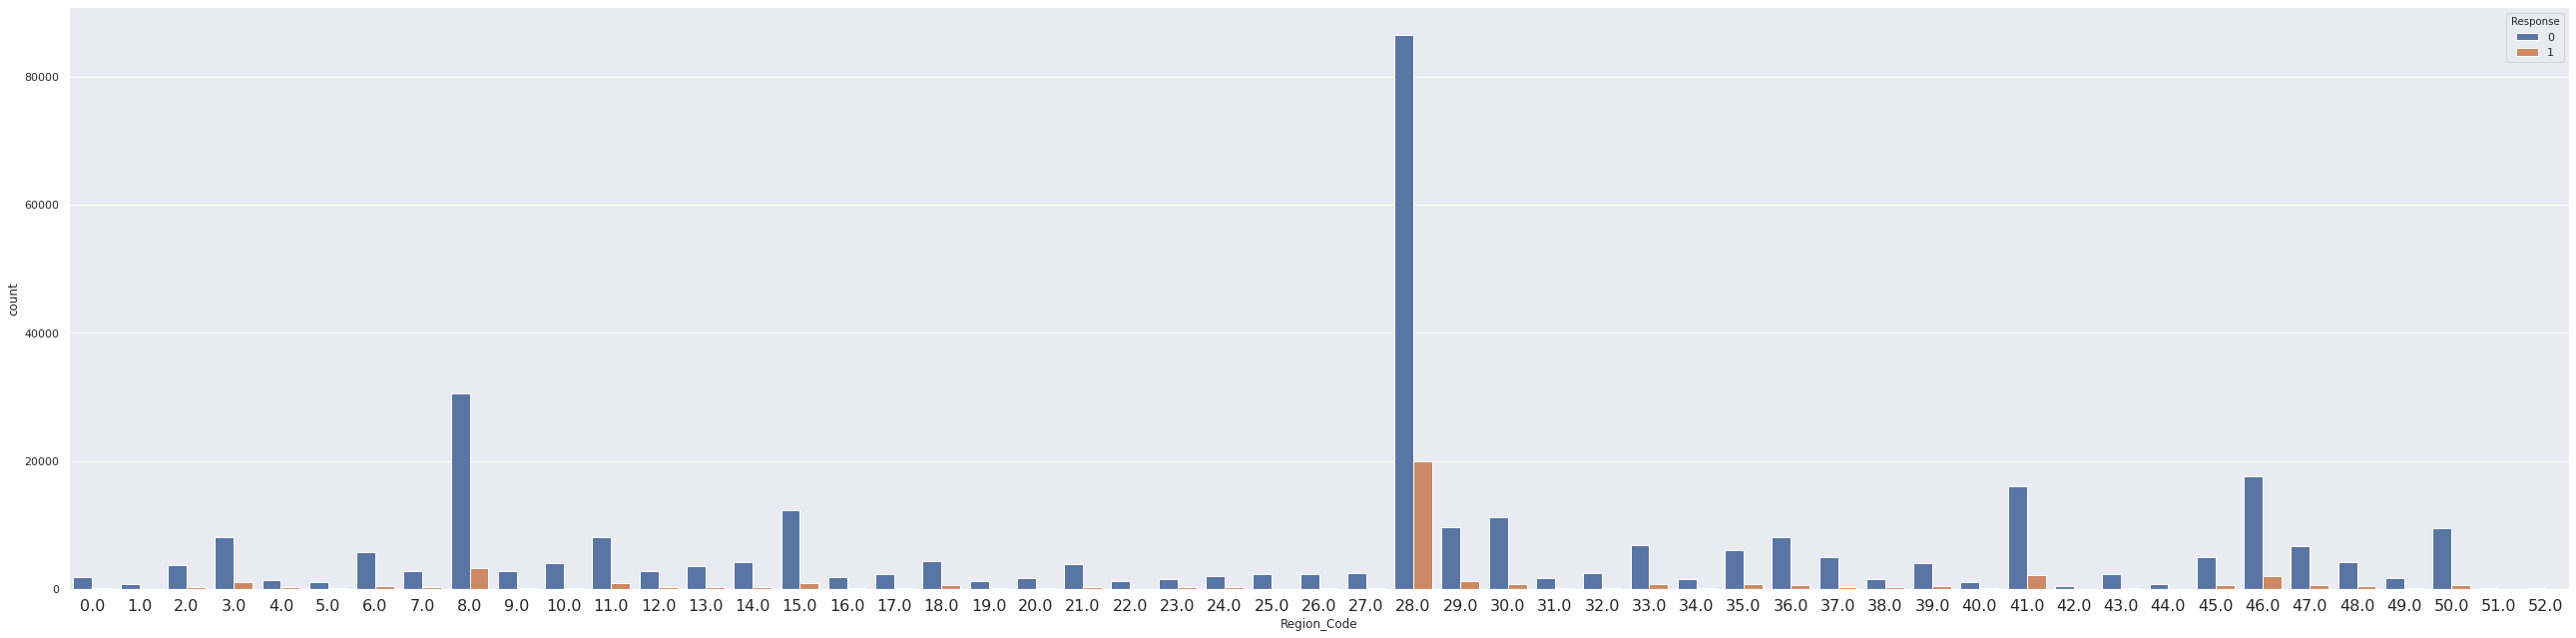

In [19]:
countplot(dataset=train_df, x='Region_Code', y='Response', size=(40,10), is_x_large=True)

<BarContainer object of 53 artists>

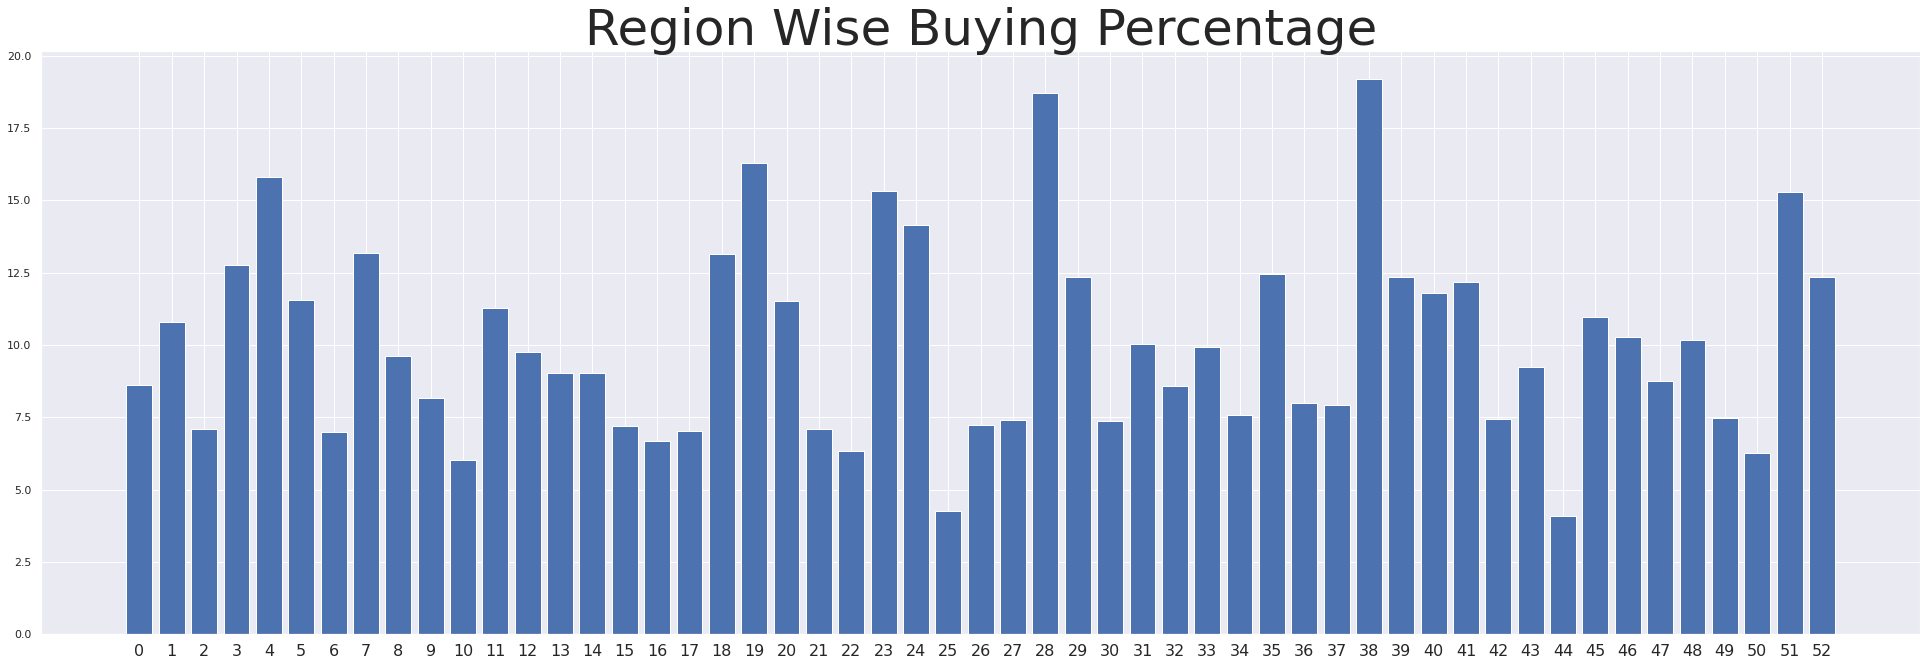

In [20]:
unique_regions = train_df['Region_Code'].unique()
region_perc = {}

for region in unique_regions:
    total_in_region = train_df[train_df['Region_Code'] == region].shape[0]
    total_purchased_in_region = train_df[(train_df['Region_Code'] == region) & (train_df['Response'] == 1)].shape[0]
    purchase_perc = round((total_purchased_in_region * 100.0) / total_in_region, 2)
    region_perc[region] = purchase_perc
    
regionwise_list = sorted(region_perc.items(), key=lambda x: x[1], reverse=True) # sorted by key, return a list of tuples
region, purchase_perc = zip(*regionwise_list) # unpack a list of pairs into two tuples

sns.set(font_scale=1)
plt.figure(figsize=(30,10))
plt.title('Region Wise Buying Percentage',fontsize=50)
plt.xticks(fontsize=16)
plt.xticks(region)
plt.bar(region, purchase_perc)

# 5. Previously Insured

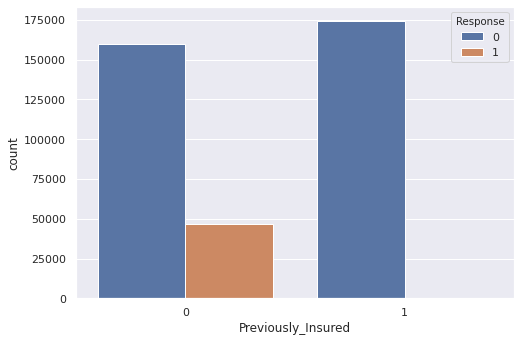

In [21]:
countplot(dataset=train_df, x='Previously_Insured', y='Response')

# 6. Vehicle Age

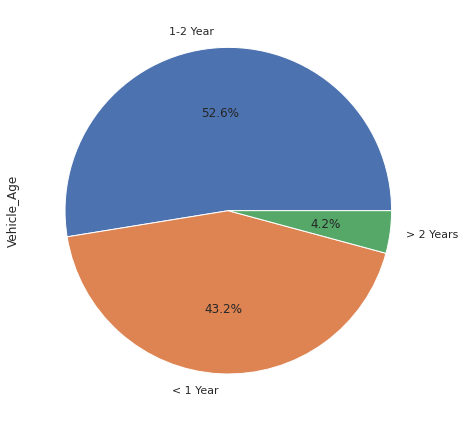

In [22]:
plot_pie(train_df, 'Vehicle_Age')

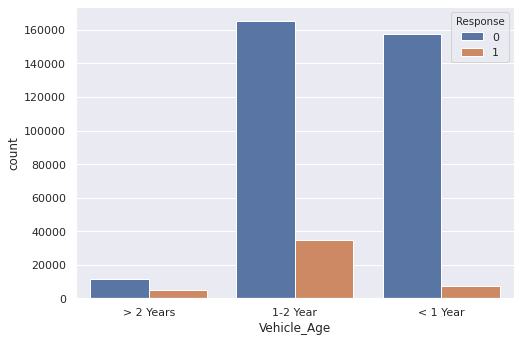

In [23]:
countplot(dataset=train_df, x='Vehicle_Age', y='Response')

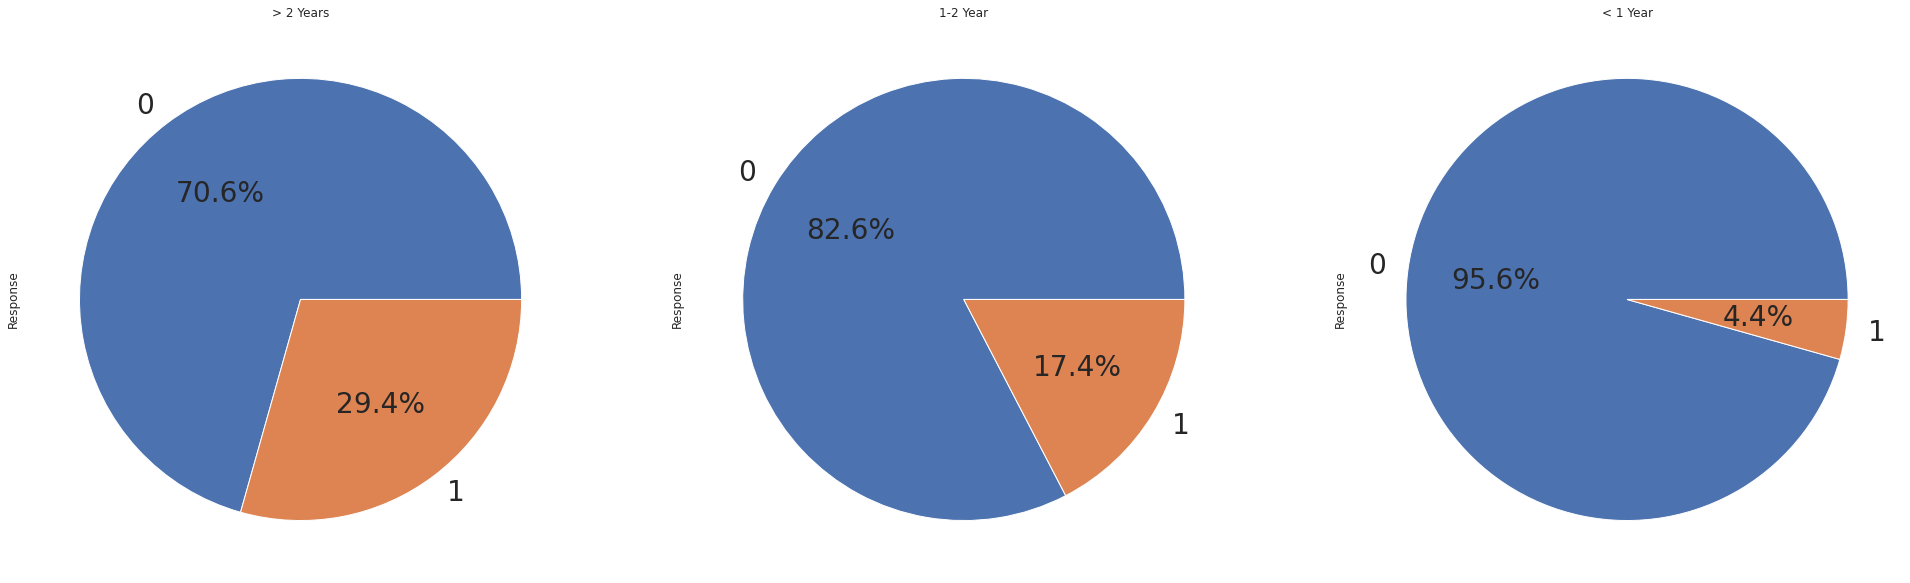

In [24]:
va = train_df['Vehicle_Age'].unique()

f,ax = plt.subplots(nrows=1, ncols=len(va), figsize = (30,10))
axx = ax.flatten()

for pos,val in enumerate(va):
    axx[pos].set_title(str(val))
    train_df[train_df['Vehicle_Age'] == val]['Response'].value_counts().plot.pie(autopct='%1.1f%%',ax=axx[pos], textprops={'fontsize': 28})

# 7. Vehicle Damage

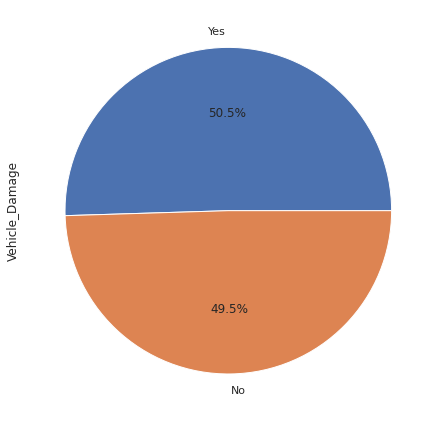

In [25]:
plot_pie(train_df, 'Vehicle_Damage')

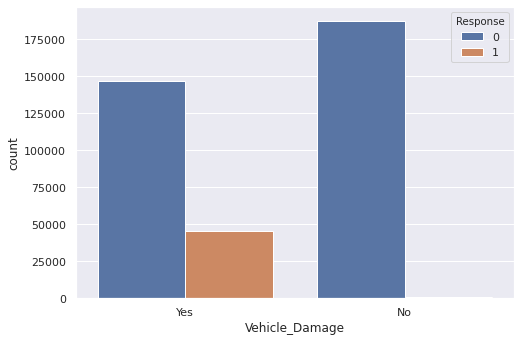

In [26]:
countplot(train_df, x='Vehicle_Damage', y='Response')

# 8. Annual Premium

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4361934450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43618df2d0>)

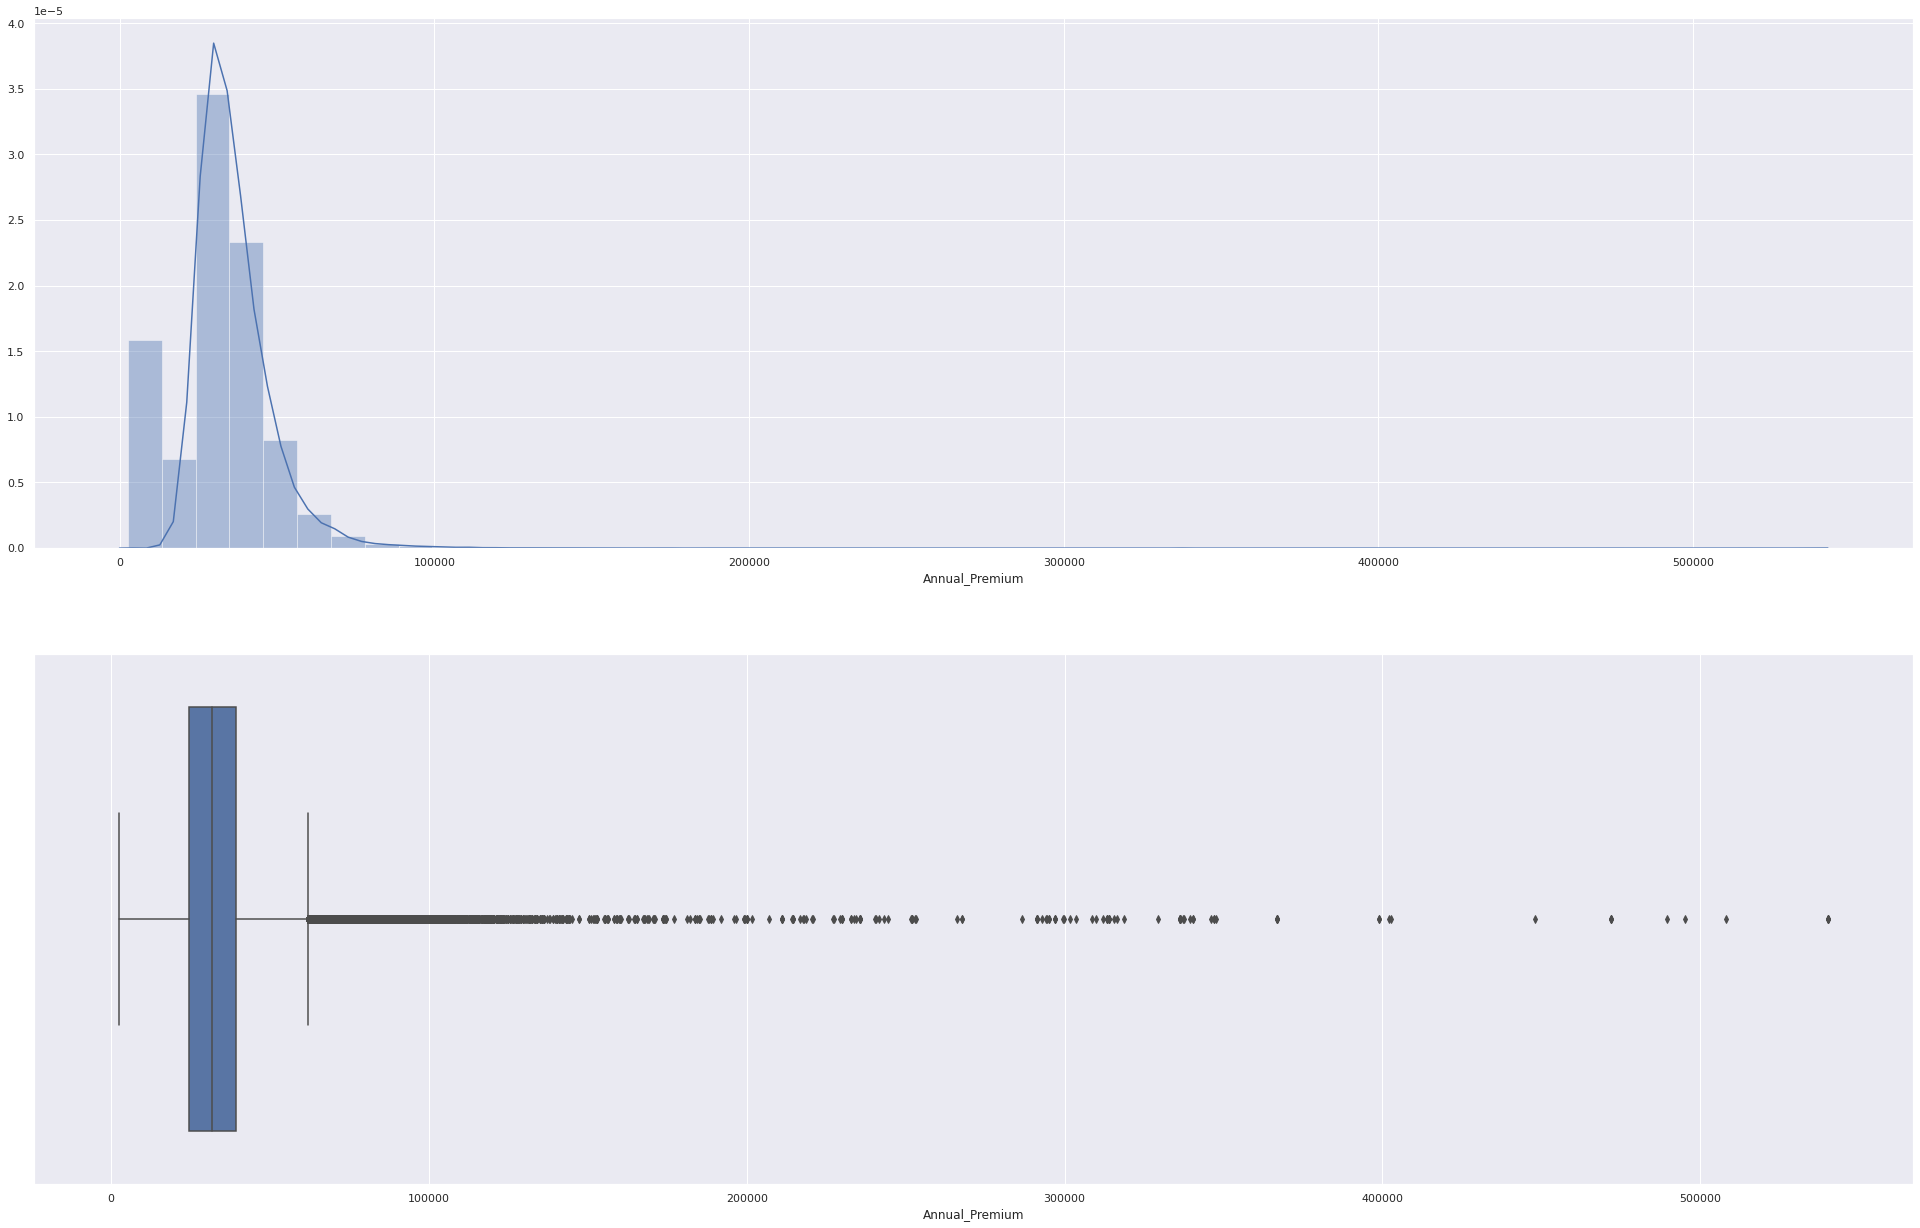

In [27]:
dist_and_box_plots(train_df, feature='Annual_Premium')

# Plotting Annual Premium less than 1L

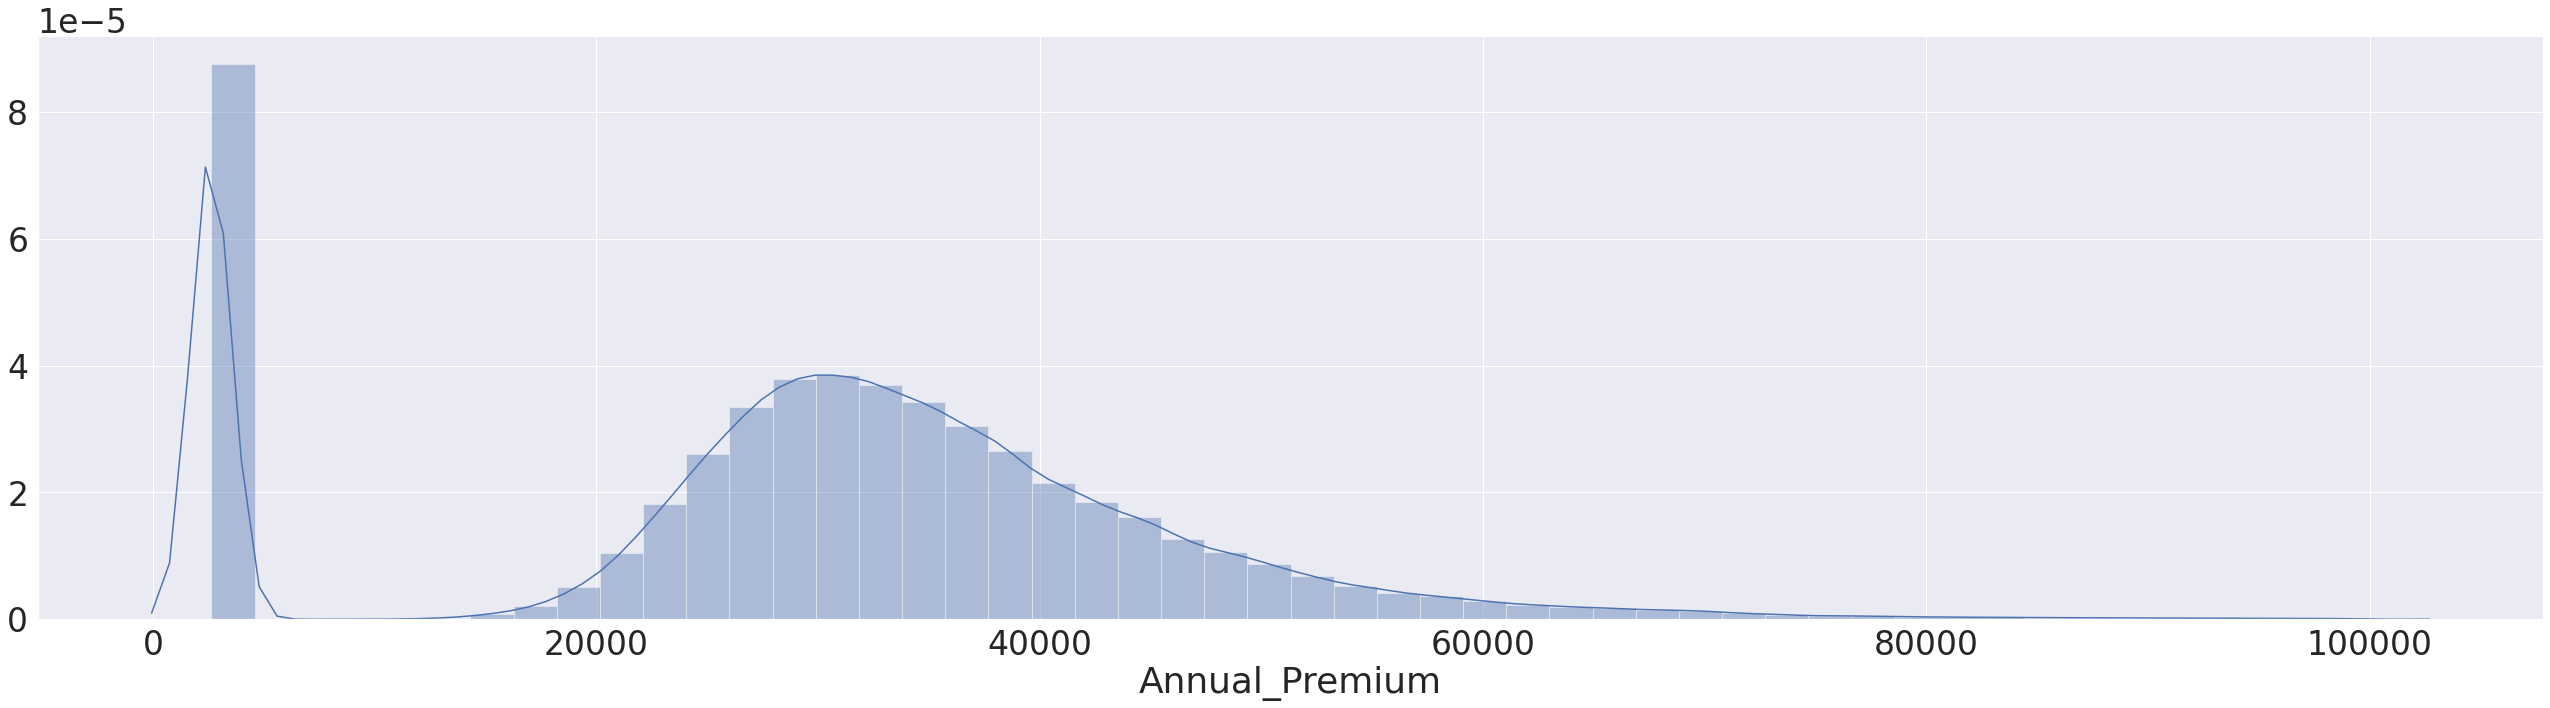

In [28]:
plt.figure(figsize=(40,10))
sns.set(font_scale=3)
sns.distplot(train_df[train_df['Annual_Premium'] < 100000]['Annual_Premium'])

## We will check the buying percentage of each bucket in this range, bucket size=10,000

In [29]:
first, last, bucket_size = 0, 100000, 10000
buckets = [(i, i+bucket_size) for i in range(first, last, bucket_size)]
# buckets

for b in buckets:
    bucket_count = train_df[train_df['Annual_Premium'].between(b[0],b[1])].shape[0]
    buy_count = train_df[(train_df['Annual_Premium'].between(b[0],b[1])) & (train_df['Response'] == 1)].shape[0]
    buy_perc = (buy_count / bucket_count) * 100.0
    print("Bucket no. between", b, bucket_count, buy_count ,buy_perc)
    


Bucket no. between (0, 10000) 64882 8506 13.109953453962579
Bucket no. between (10000, 20000) 5803 456 7.858004480441151
Bucket no. between (20000, 30000) 95393 9575 10.03742412965312
Bucket no. between (30000, 40000) 125062 14998 11.992451743935009
Bucket no. between (40000, 50000) 57793 8280 14.32699461872545
Bucket no. between (50000, 60000) 20050 3060 15.261845386533665
Bucket no. between (60000, 70000) 7271 1115 15.334892036858754
Bucket no. between (70000, 80000) 2524 358 14.183835182250396
Bucket no. between (80000, 90000) 1030 153 14.854368932038836
Bucket no. between (90000, 100000) 557 90 16.15798922800718


# 9. Policy_Sales_Channel

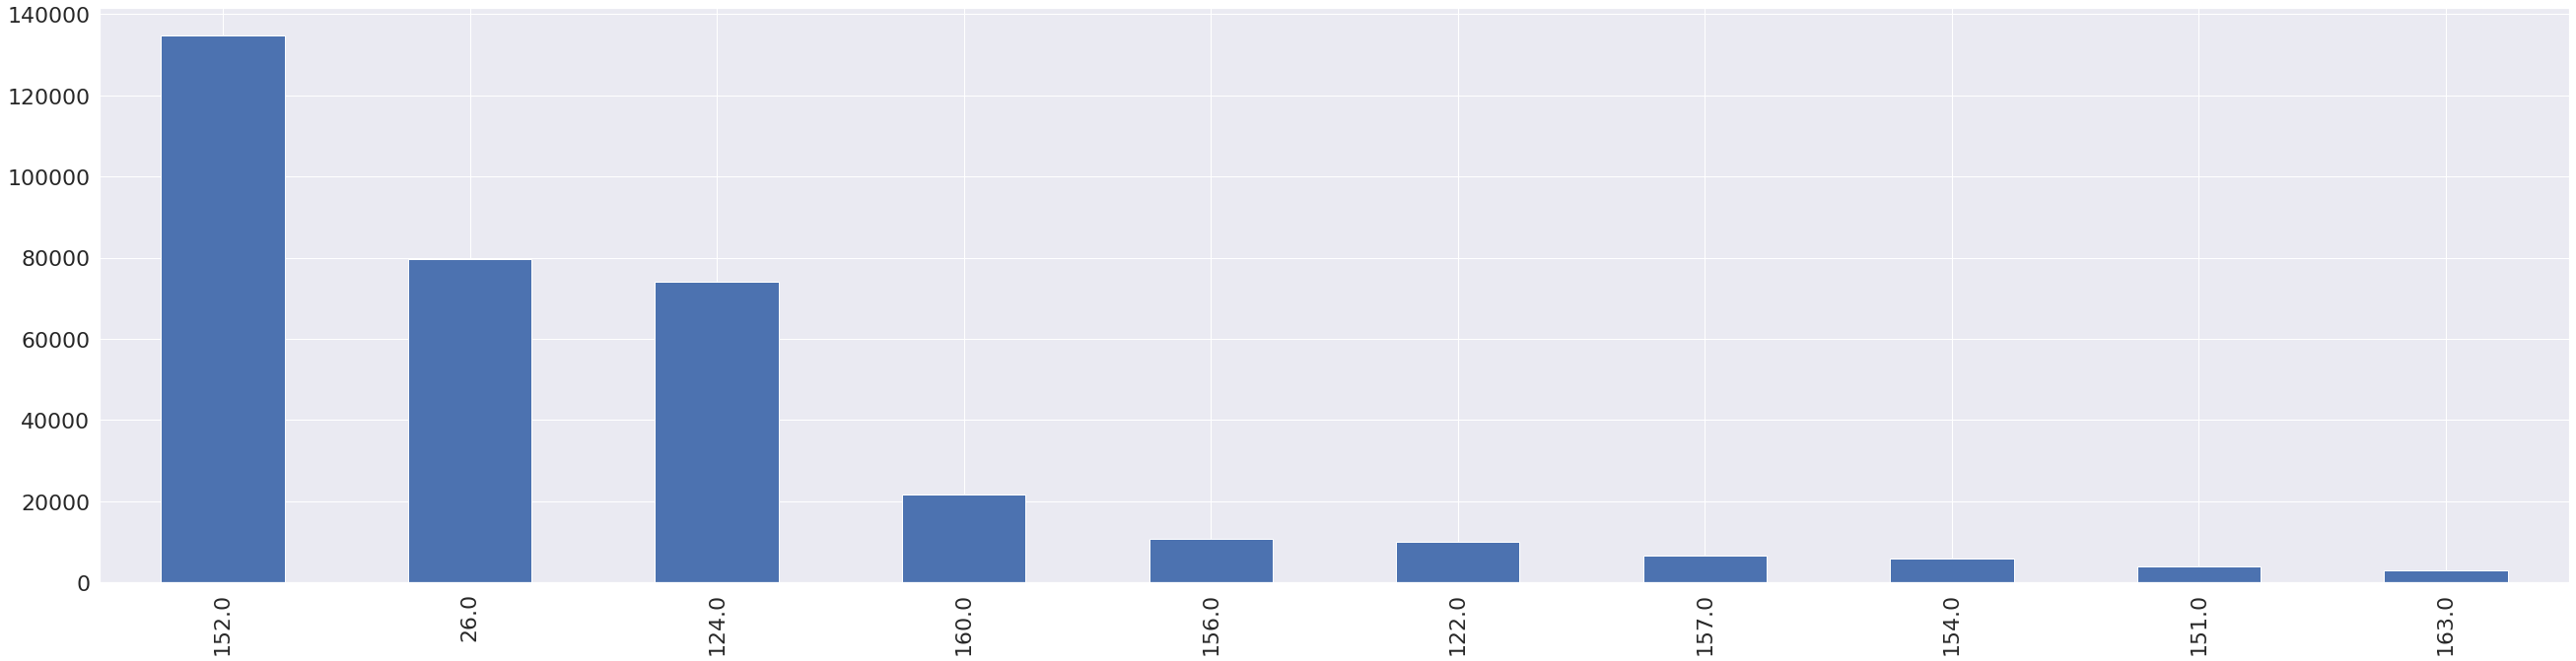

In [30]:
plt.figure(figsize=(40,10))
sns.set(font_scale=2)
# Plotting top 20 channels
train_df['Policy_Sales_Channel'].value_counts().nlargest(10).plot.bar()
# .plot.bar()#.nlargest(20).plot.bar()

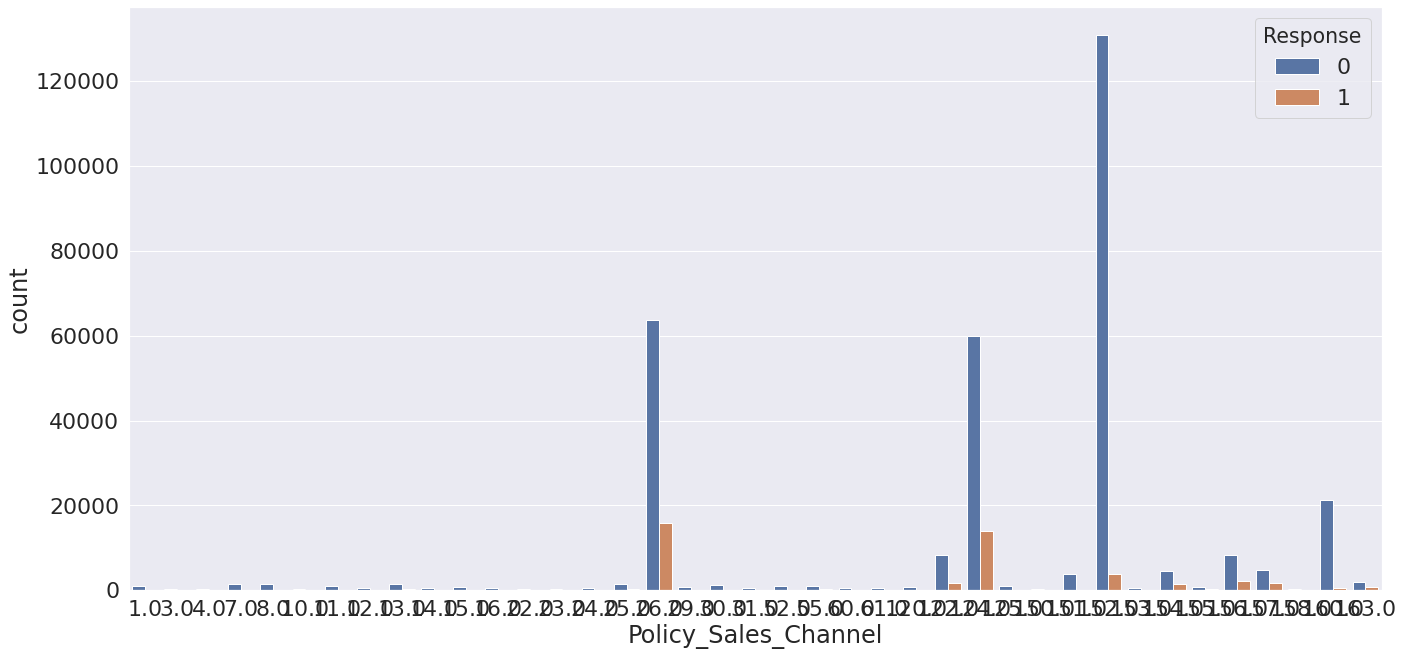

In [31]:
plt.figure(figsize=(20,10))
top_channels = train_df['Policy_Sales_Channel'].value_counts()[:10].index.tolist()
top_channels_df = train_df[train_df['Policy_Sales_Channel'].isin(top_channels)]
# top_channels_df

sns.countplot(top_channels_df['Policy_Sales_Channel'], hue=top_channels_df['Response'])

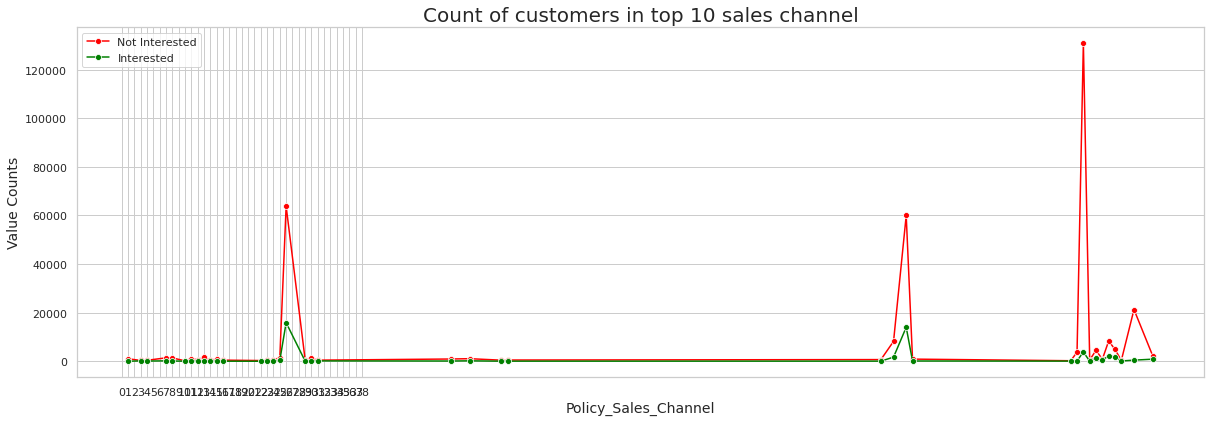

In [32]:
def make_lineplot_bva(dataset, feature, target, labels, title):
    unq_vals_in_feat = dataset[feature].nunique()
    
    feat_as_idx_tgt0 = dataset[feature][dataset[target] == 0].value_counts().index
    feat_as_idx_tgt1 = dataset[feature][dataset[target] == 1].value_counts().index

    feat_as_pct_tgt0 = dataset[feature][dataset[target] == 0].value_counts()
    feat_as_pct_tgt1 = dataset[feature][dataset[target] == 1].value_counts()
    
    plt.figure(figsize=(18,6))
    sns.set_style('whitegrid')
    sns.lineplot(x=feat_as_idx_tgt0, y=feat_as_pct_tgt0, marker='o', color='red', label=labels[0])
    sns.lineplot(x=feat_as_idx_tgt1, y=feat_as_pct_tgt1, marker='o', color='green', label=labels[1])
    plt.xticks(range(0,unq_vals_in_feat))
    plt.title(title, fontsize=20)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Value Counts', fontsize=14)

sns.set(font_scale=1)
make_lineplot_bva(top_channels_df, 'Policy_Sales_Channel', 'Response', labels=['Not Interested', 'Interested'], title='Count of customers in top 10 sales channel')

# 10. Vintage

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4363225f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4360c8f990>)

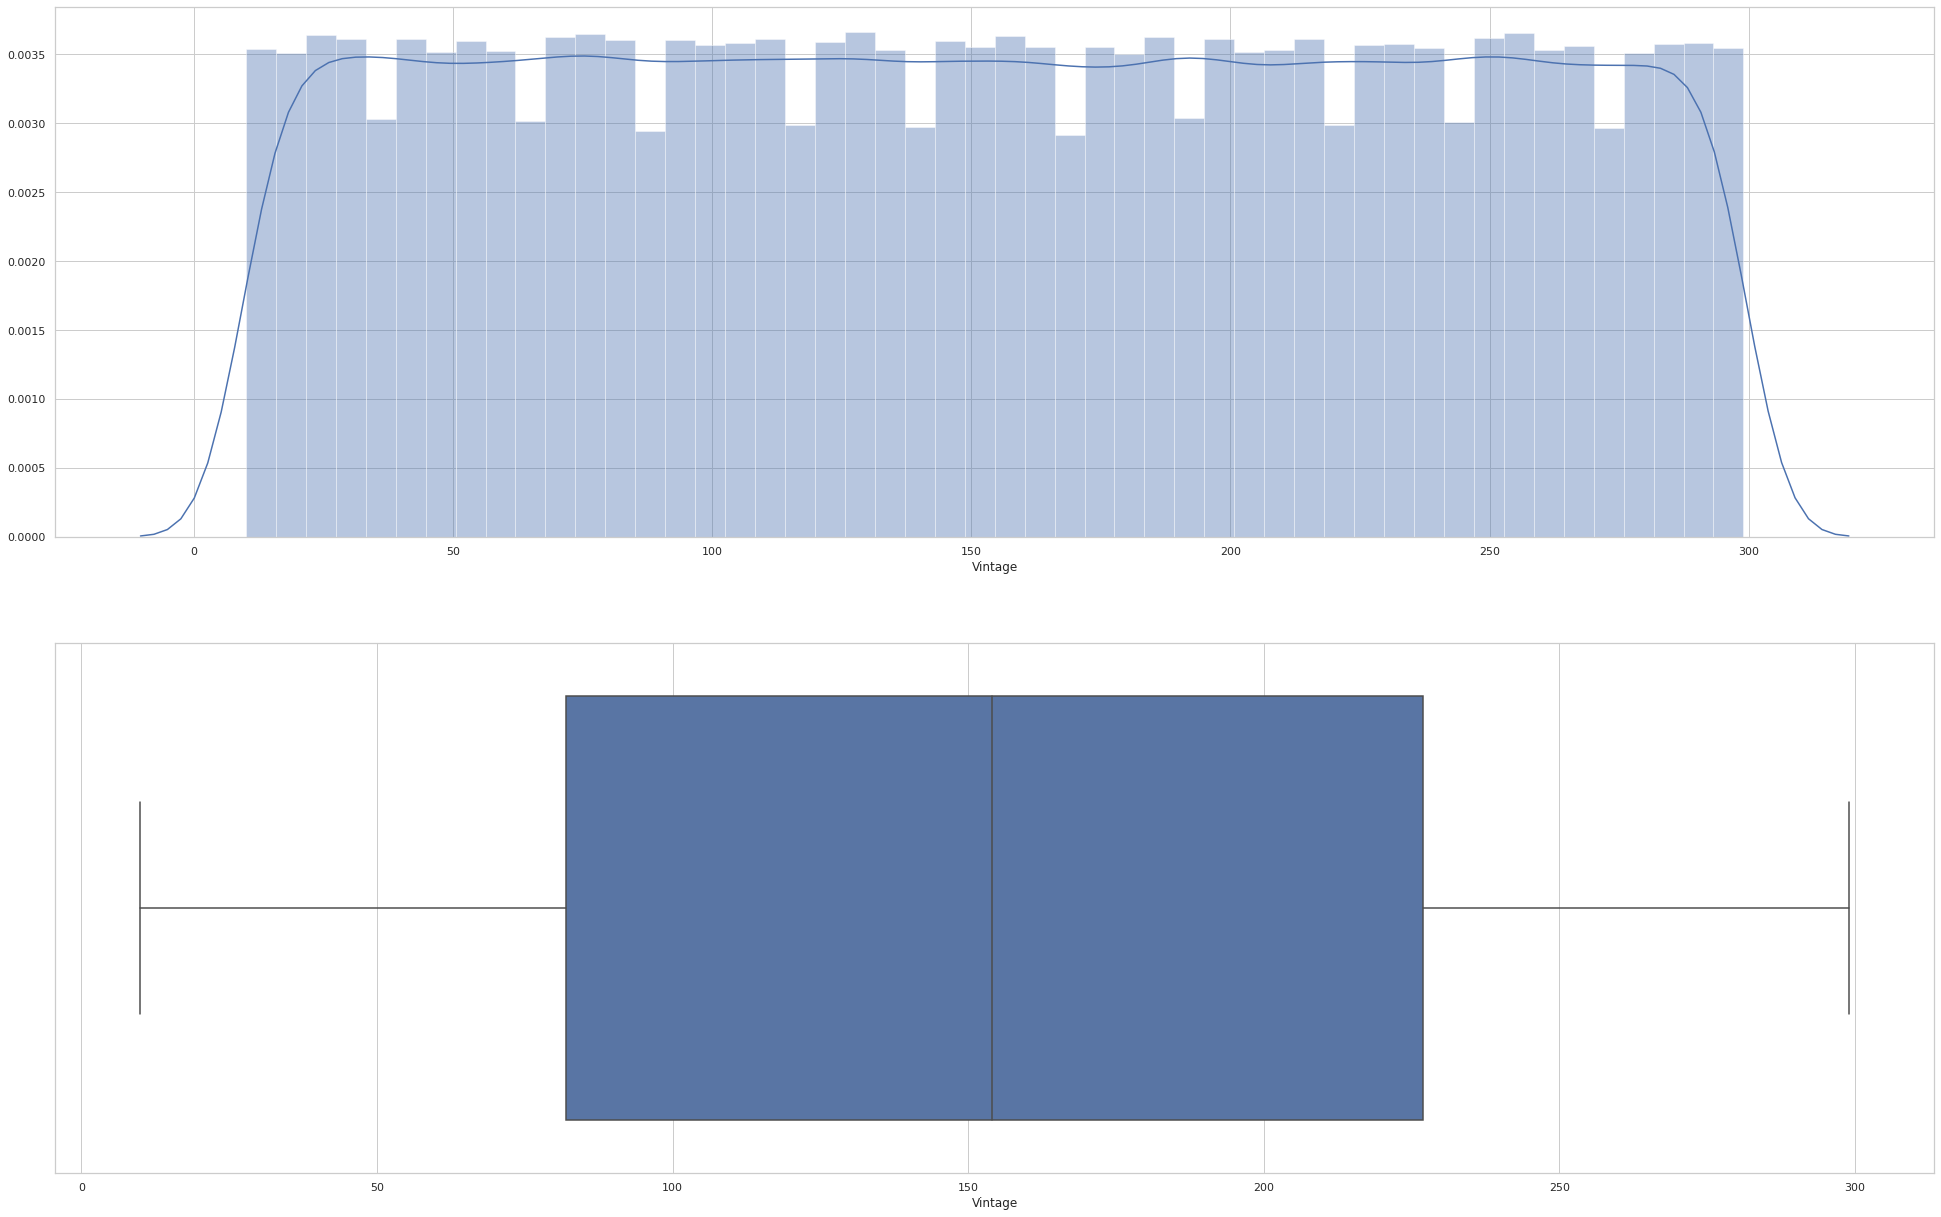

In [33]:
dist_and_box_plots(train_df, feature='Vintage')

# Correlation Matrix

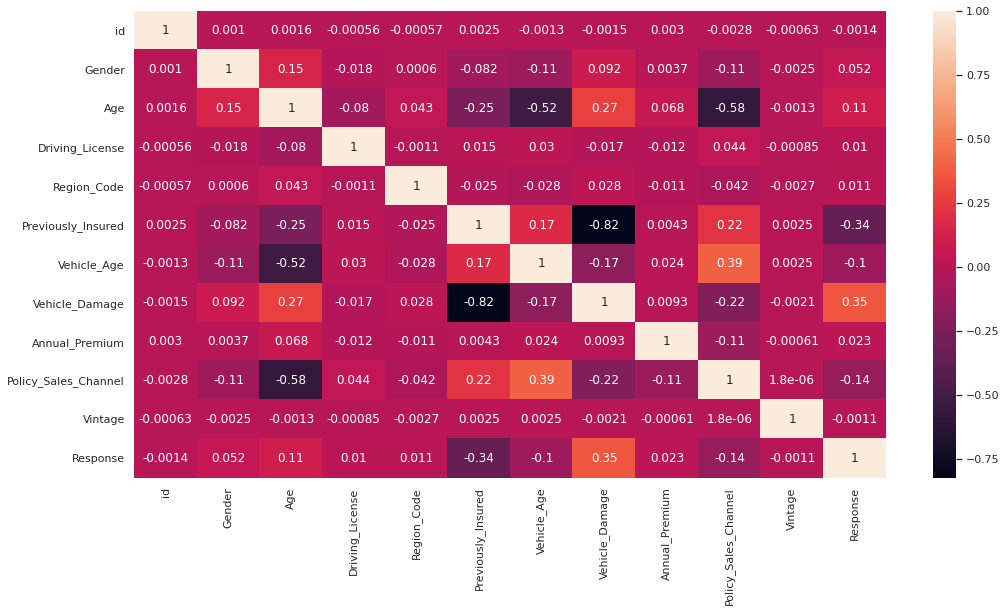

In [34]:
# label encoding categorical variables to include in correlation matrix
train_corr = train_df.copy()
cat_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
le = LabelEncoder()

for col in cat_cols:
    train_corr[col] = le.fit_transform(train_corr[col])

plt.figure(figsize=(15,8))
sns.heatmap(train_corr.corr(), annot=True)

# Vehicle Damage and Previously Insured have very highly negatively correlation
# Age and Policy Channel have moderate negative correlation
# Age and Vehicle Age have moderate negative correlation

# Final Insights
##### 1. Customers with age between 30 to 60 are more likely to buy insurance.
##### 2. Customers with age between 20 to 30 are less likely to buy insurance.
##### 3. In almost every age group, __Males__ are more likely to buy insurance.
##### 4. Females under the age 30 are very less likely to buy insurance.
##### 5. Very few customers don't have Driving License.
##### 6  Customers with Driving License have higher chance of buying Insurance.
##### 7. Most of the customers belong to `Region_Code : 28`
##### 8. `Region_Codes: [4,19,23,24,28,38,51]` have higher percentage of buying insurance.
##### 9. `Region_Codes: 25 and 44` have lower percentage of buying insurance.
##### 10. Customers who are `Previously_Insured` are very likely to buy Insurnce even now.
##### 11. Customers who aren't Previously_Insured have good chance of buying Insurnce.
##### 12. More than 50% of our customers have Vehicles aged between 1-2 years.
##### 13. Very few customers (4.2%) have Vehicles aged more than 2 years.
##### 14. Customers with `Vehicle_Age >2years` have better chance (29.4%) of buying Insurance.
##### 15. Customers with with `Vehicle_Age <1` years have very less chance of buying Insurance.
##### 16. We have almost same number of customes with damaged and non_damaged vehicle.
##### 17. Customers whose vehicles are damaged are likely to buy insurance.
##### 18. Customers whose vehicles are not damaged have least chance (less than 1%) of buying insurance.
##### 19. `Annual Premium` feature is highly left skewed.
##### 20. Most of the customers have "Annual_Premium' in range (0, 10000) and (20000 to 50000)
##### 21. In every 'Annual Premium' range, the insurance buy percentage is almost same.
##### 22. `Policy_Sales_Channel no. 152` have higest number of customers.
##### 23. `Policy_Sales_Channel no. [152,26,124,160,156,122,157,154,151,163]` have most of the customers.
##### 24. 'Vintage' has a uniform distribution.

# Utility Functions

In [35]:
# function to check if there is any duplicate entries in the dataset
def check_duplicates(dataset):
    return dataset.duplicated().sum()

In [36]:
# function to change datatypes
def transform_dtypes(dataset, columns, convert_to='object'):
    """
    Function takes in the dataset and list of columns 
    and returns a new dataset with converted columns. Default='object' 
    """
    for c in columns:
        dataset[c] = dataset[c].astype(convert_to)
    
    return dataset   

In [37]:
train_df = transform_dtypes(train_df, ['Driving_License', 'Region_Code', 'Response', 'Vehicle_Age', 'Previously_Insured'])
test_df = transform_dtypes(test_df, ['Driving_License', 'Region_Code', 'Vehicle_Age', 'Previously_Insured'])

In [38]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  object 
 4   Region_Code           381109 non-null  object 
 5   Previously_Insured    381109 non-null  object 
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 34.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 

(None, None)

# Univariate Analysis (Categorical Variables)

In [39]:
def UVA_Cat(data, column, rot=0):
    """
    Function to plot countplot and pie chart for categorical variables.
    
    """
    for j, i in enumerate(column):
        
        #plt.subplot(2,1, j+1)
        
        # Setting the figure size
        plt.figure(figsize=(10,3), dpi=100)
    
    
        # ploting the barplot
        plt.subplot(1,2,1)
        g=sns.countplot(x=i, data= data)
        plt.title('Barplot for {}'.format(i), fontsize=14)
        plt.xticks(rotation=rot)
        plt.tight_layout()
        
        #ploting the pie chart 
        plt.subplot(1,2,2)
        plt.axis('equal')
        plt.pie(x= data[i].value_counts(), labels= data[i].value_counts().index, autopct='%0.1f%%', shadow=True)
        plt.title('Pie chart for {}'.format(i), fontsize=14)
        plt.tight_layout()
        plt.show()

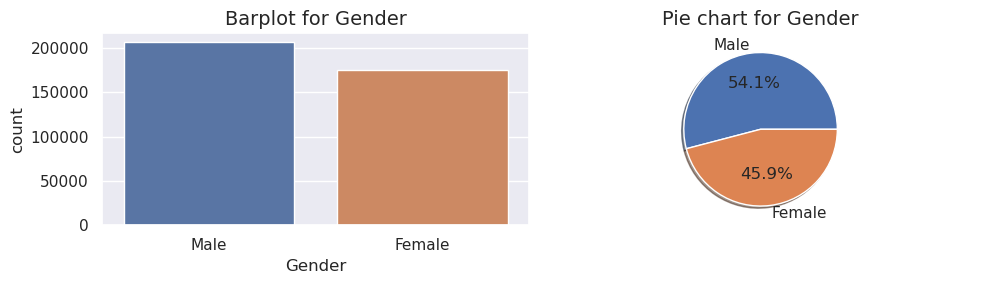

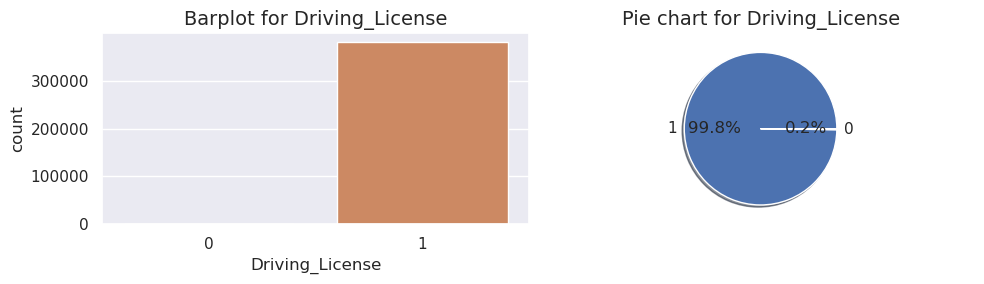

In [40]:
UVA_Cat(train_df, ['Gender', 'Driving_License'])

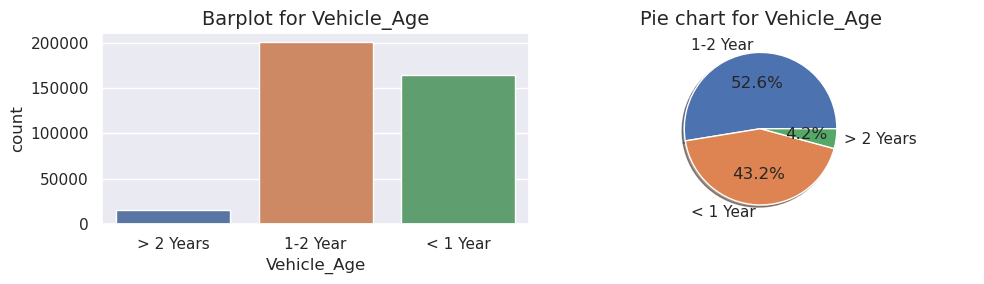

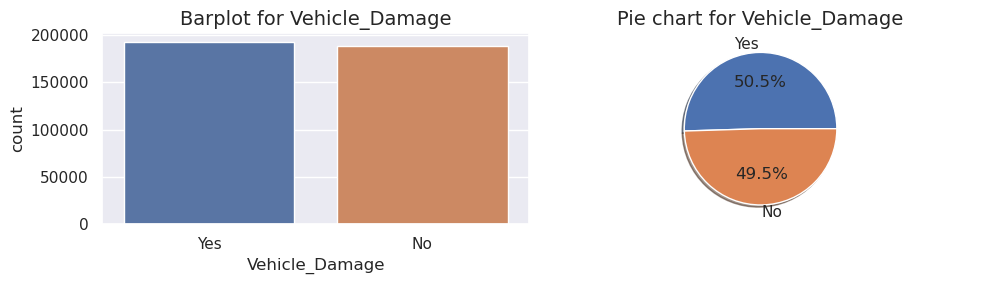

In [41]:
UVA_Cat(train_df, ['Vehicle_Age', 'Vehicle_Damage'])

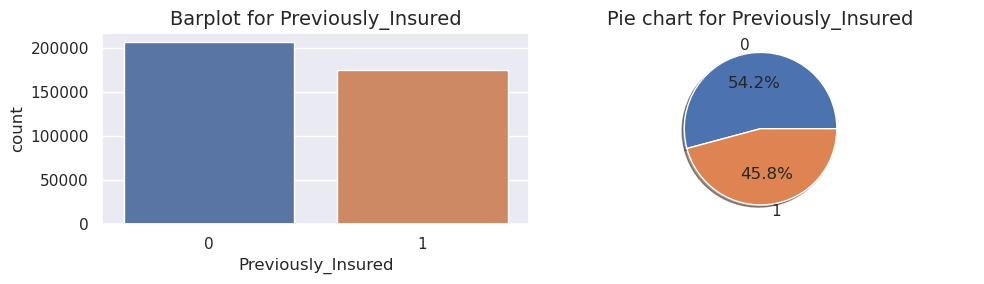

In [42]:
UVA_Cat(train_df, ['Previously_Insured'])

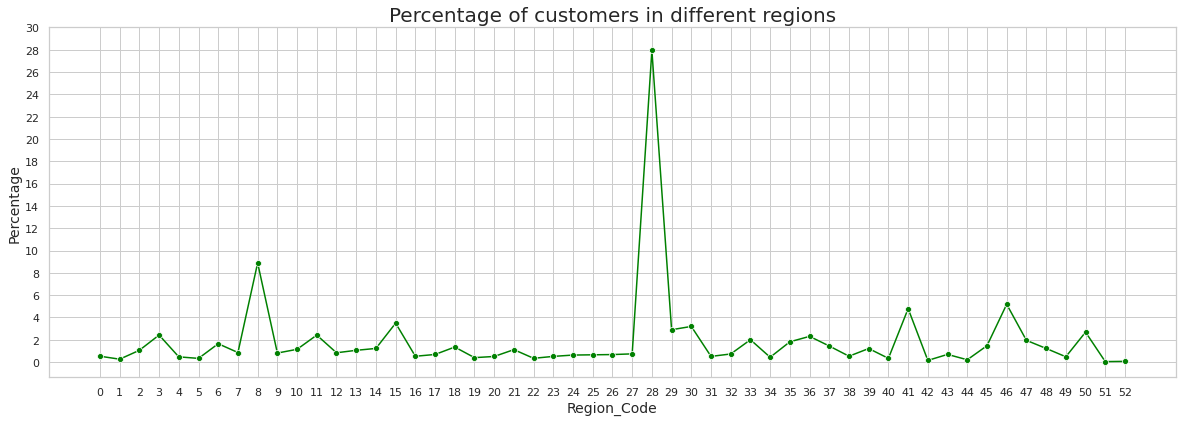

In [43]:
def make_lineplot(dataset, feature, title):
    unq_vals_in_feat = dataset[feature].nunique()
    feat_as_idx = dataset[feature].value_counts().index
    feat_as_pct = dataset[feature].value_counts(normalize=True)*100
    
    plt.figure(figsize=(18,6))
    sns.set_style('whitegrid')
    sns.lineplot(x=feat_as_idx, y=feat_as_pct, marker='o', color='green')
    plt.xticks(range(0,unq_vals_in_feat))
    plt.yticks(range(0,31,2))
    plt.title(title, fontsize=20)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Percentage', fontsize=14)

make_lineplot(train_df, 'Region_Code', title='Percentage of customers in different regions')

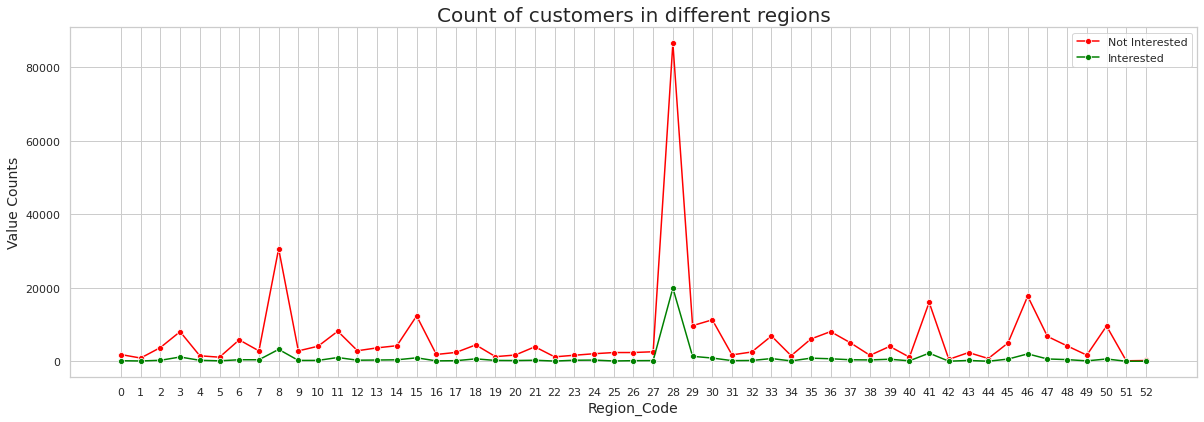

In [44]:
make_lineplot_bva(train_df, 'Region_Code', 'Response', labels=['Not Interested', 'Interested'], title='Count of customers in different regions')

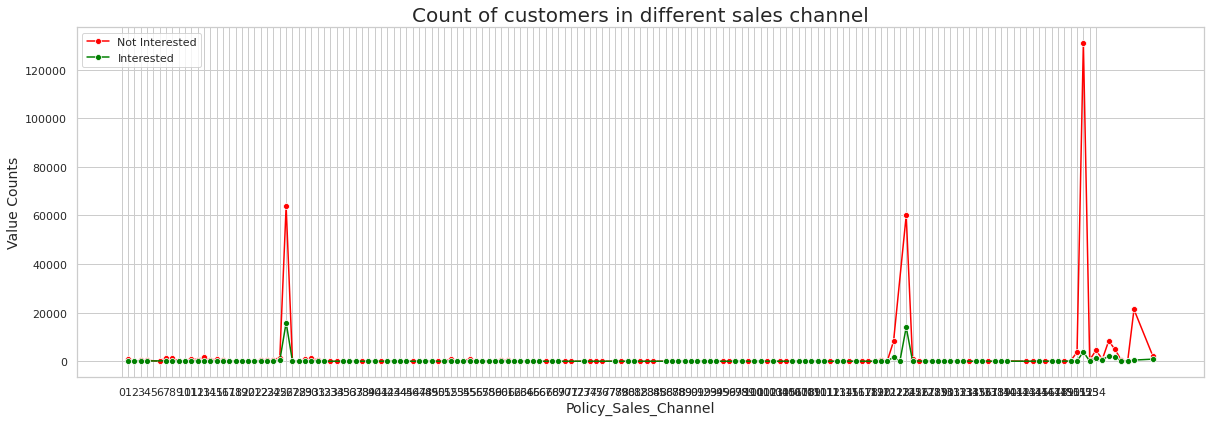

In [45]:
make_lineplot_bva(train_df, 'Policy_Sales_Channel', 'Response', labels=['Not Interested', 'Interested'], title='Count of customers in different sales channel')

In [46]:
# Pre Processing
# 1. binning Annual_Premium to tackle bi modal nature of the data
# 2. performing frequency encoding on Region_Code and Policy_Sales_Channel -- can revisit this
# 3. Label Encoding Gender, Vehicle_Age and Vehicle_Damage

In [47]:
# binning Annual_Premium to tackle bi modal nature of the data
train_df['Annual_Premium_Binned'] = train_df['Annual_Premium'].apply(lambda x: 3 if x>60000 else (1 if x<10000 else 2 ))
test_df['Annual_Premium_Binned'] = test_df['Annual_Premium'].apply(lambda x: 3 if x>60000 else (1 if x<10000 else 2 ))

In [48]:
train_df.head(), test_df.head()

(   id  Gender  Age Driving_License Region_Code Previously_Insured Vehicle_Age  \
 0   1    Male   44               1          28                  0   > 2 Years   
 1   2    Male   76               1           3                  0    1-2 Year   
 2   3    Male   47               1          28                  0   > 2 Years   
 3   4    Male   21               1          11                  1    < 1 Year   
 4   5  Female   29               1          41                  1    < 1 Year   
 
   Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage Response  \
 0            Yes         40454.0                  26.0      217        1   
 1             No         33536.0                  26.0      183        0   
 2            Yes         38294.0                  26.0       27        1   
 3             No         28619.0                 152.0      203        0   
 4             No         27496.0                 152.0       39        0   
 
    Annual_Premium_Binned  
 0            

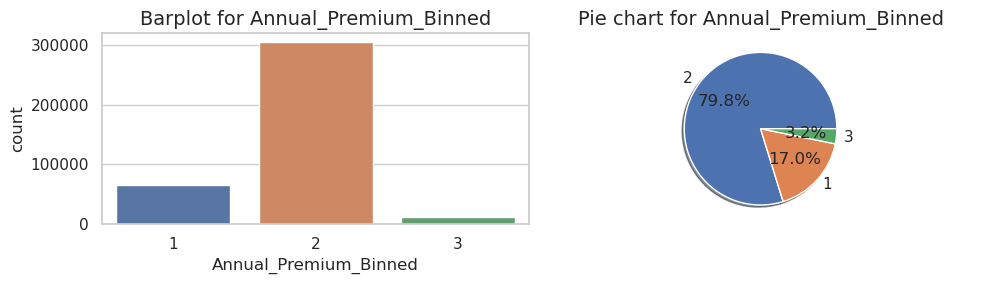

In [49]:
UVA_Cat(train_df, ['Annual_Premium_Binned'])

In [50]:
# 3. Label Encoding Gender, Vehicle_Age and Vehicle_Damage
# Creating dictionaries for encoding 
gender_dict = {'Male':1, 'Female':0}
age_dict = {'> 2 Years': 3, '1-2 Year': 2, '< 1 Year': 1}
damage_dict = {'Yes':1, 'No':0}

# Encoding train variables
train_df['Gender'] = train_df['Gender'].replace(gender_dict)
train_df['Vehicle_Age'] = train_df['Vehicle_Age'].replace(age_dict)
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].replace(damage_dict)

# Encoding test variables
test_df['Gender'] = test_df['Gender'].replace(gender_dict)
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].replace(age_dict)
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].replace(damage_dict)


In [51]:
# 4. Adding vintage as monthly_vintage
train_df['Vintage_Monthly'] = train_df['Vintage']/30.25
test_df['Vintage_Monthly'] = test_df['Vintage']/30.25

train_df = train_df.drop(['Vintage'], axis=1)
test_df = test_df.drop(['Vintage'], axis=1)

# Splitting into train and validation

In [52]:
# Splitting the features and target variables
train_df['Response'] = train_df['Response'].astype(int)

X = train_df.drop(['id', 'Response'], axis=1)
y = train_df['Response']

# final = test.drop('id', axis=1)

# Train-Val split 75-25
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=101, test_size = 0.25)

# Standardazing the data

In [53]:
scaler = StandardScaler()

# Scaling x_train data
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Scaling x_test data 
X_val_scaled = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

#Scaling test data 
# final_scaled = scaler.transform(final)
# final = pd.DataFrame(final_scaled, columns= final.columns)

In [54]:
lr = LogisticRegression(random_state=555)

lrParameters = {
    "class_weight" : ['balanced'],
    "C": [100, 10, 1.0, 0.1, 0.01], 
}



lrModel = GridSearchCV(lr, param_grid=lrParameters, cv=StratifiedKFold(), n_jobs=-1, scoring='roc_auc', verbose=1)


start = time.time()
lrModel.fit(X_train, y_train)
end = time.time()

print('Training for Logistic Regression took {:.2f} mins'.format((end-start)/60))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.5s finished


Training for Logistic Regression took 0.16 mins


In [55]:
bestLR = lrModel.best_estimator_
bestLR

LogisticRegression(C=100, class_weight='balanced', random_state=555)

In [56]:
bestLR.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', random_state=555)

In [57]:
lr_probs = bestLR.predict_proba(X_val)[:,1]
lr_probs

array([0.76175852, 0.00485503, 0.7611865 , ..., 0.66798329, 0.00338354,
       0.56373219])

In [58]:
lr_score = bestLR.score(X_val, y_val) 
lr_score

0.6398853880224186

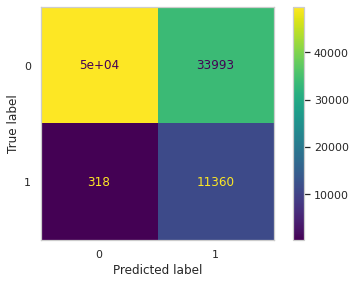

In [59]:
lr_preds = bestLR.predict(X_val)
cm = confusion_matrix(y_val, lr_preds)

plot_confusion_matrix(bestLR, X_val, y_val)
plt.grid(b=None)
plt.show()

In [60]:
cr_lr = classification_report(y_val, lr_preds)
print(cr_lr)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     83600
           1       0.25      0.97      0.40     11678

    accuracy                           0.64     95278
   macro avg       0.62      0.78      0.57     95278
weighted avg       0.90      0.64      0.70     95278



# We can use SMOTe to tackle this

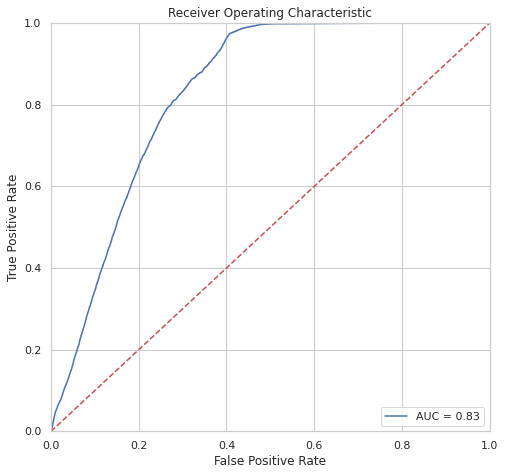

In [61]:
roc_auc = roc_auc_score(y_val, lr_probs)

fpr, tpr, thresholds = roc_curve(y_val, lr_probs) 
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Baseline logistic regression is getting us at 0.83

In [62]:
from imblearn.over_sampling import SMOTE

# splitting training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=101, test_size=0.25)

scaler = StandardScaler()

# Scaling x_train data
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Scaling x_test data 
X_val_scaled = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

sm = SMOTE(random_state=27, sampling_strategy='auto')
X_train, y_train = sm.fit_sample(X_train, y_train)

1. # Using SMOTe

In [63]:
lr = LogisticRegression(random_state=555)

lrParameters = {
    "class_weight" : ['balanced'],
    "C": [100, 10, 1.0, 0.1, 0.01], 
}



lrModel = GridSearchCV(lr, param_grid=lrParameters, cv=StratifiedKFold(), n_jobs=-1, scoring='roc_auc', verbose=1)


start = time.time()
lrModel.fit(X_train, y_train)
end = time.time()

print('Training for Logistic Regression took {:.2f} mins'.format((end-start)/60))

bestLR = lrModel.best_estimator_
bestLR

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.8s finished


Training for Logistic Regression took 0.22 mins


LogisticRegression(C=100, class_weight='balanced', random_state=555)

In [64]:
bestLR.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', random_state=555)

In [65]:
lr_probs = bestLR.predict_proba(X_val)[:,1]
lr_probs

array([0.76150806, 0.00381858, 0.76234346, ..., 0.66461259, 0.00268668,
       0.56282528])

In [66]:
lr_score = bestLR.score(X_val, y_val) 
lr_score

0.64001133525053

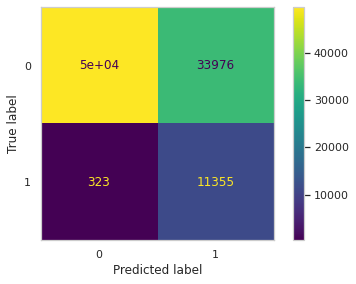

In [67]:
lr_preds = bestLR.predict(X_val)
cm = confusion_matrix(y_val, lr_preds)

plot_confusion_matrix(bestLR, X_val, y_val)
plt.grid(b=None)
plt.show()

In [68]:
cr_lr = classification_report(y_val, lr_preds)
print(cr_lr)

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     83600
           1       0.25      0.97      0.40     11678

    accuracy                           0.64     95278
   macro avg       0.62      0.78      0.57     95278
weighted avg       0.90      0.64      0.70     95278



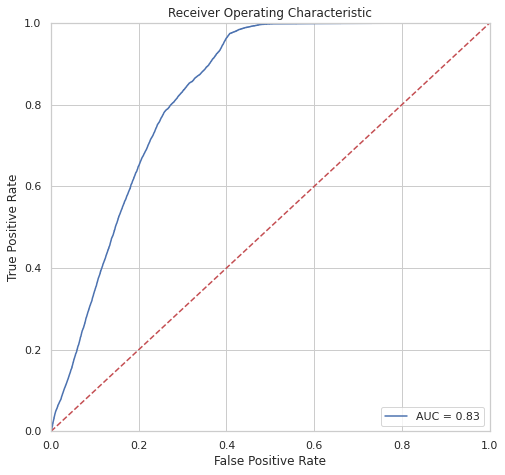

In [69]:
roc_auc = roc_auc_score(y_val, lr_probs)

fpr, tpr, thresholds = roc_curve(y_val, lr_probs) 
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [72]:
rf_model = RandomForestClassifier(random_state=101)
rf_model.fit(X_train,y_train)
print("Training accuracy",rf_model.score(X_train,y_train))
print("Validation accuracy",rf_model.score(X_val,y_val))

Training accuracy 0.9999401911490875
Test accuracy 0.8343164214194253


# Random forest is overfitting

In [82]:
rf_probs = rf_model.predict_proba(X_val)[:,1]
rf_probs

array([0.75, 0.  , 0.35, ..., 0.42, 0.  , 0.14])

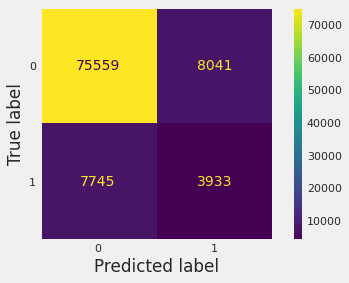

In [79]:
rf_preds = rf_model.predict(X_val)
cm = confusion_matrix(y_val, rf_preds)

plot_confusion_matrix(rf_model, X_val, y_val)
plt.grid(b=None)
plt.show()

In [81]:
cr_rf = classification_report(y_val, rf_preds)
print(cr_rf)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     83600
           1       0.33      0.34      0.33     11678

    accuracy                           0.83     95278
   macro avg       0.62      0.62      0.62     95278
weighted avg       0.84      0.83      0.84     95278



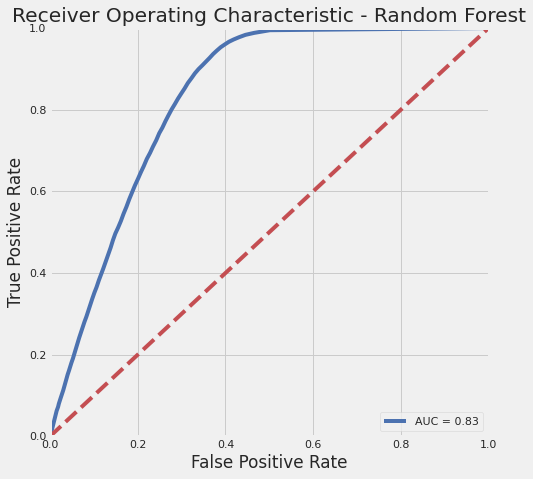

In [83]:
roc_auc = roc_auc_score(y_val, rf_probs)

fpr, tpr, thresholds = roc_curve(y_val, rf_probs) 
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [84]:
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Annual_Premium_Binned,Vintage_Monthly
0,381110,1,25,1,11,1,1,0,35786.0,152.0,2,1.752066
1,381111,1,40,1,28,0,2,1,33762.0,7.0,2,3.669421
2,381112,1,47,1,28,0,2,1,40050.0,124.0,2,6.578512
3,381113,1,24,1,27,1,1,1,37356.0,152.0,2,6.181818
4,381114,1,27,1,28,1,1,0,59097.0,152.0,2,9.818182


In [87]:
X_train.info()
print("="*50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501598 entries, 0 to 501597
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 501598 non-null  float64
 1   Age                    501598 non-null  float64
 2   Driving_License        501598 non-null  float64
 3   Region_Code            501598 non-null  float64
 4   Previously_Insured     501598 non-null  float64
 5   Vehicle_Age            501598 non-null  float64
 6   Vehicle_Damage         501598 non-null  float64
 7   Annual_Premium         501598 non-null  float64
 8   Policy_Sales_Channel   501598 non-null  float64
 9   Annual_Premium_Binned  501598 non-null  float64
 10  Vintage_Monthly        501598 non-null  float64
dtypes: float64(11)
memory usage: 42.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dt

In [88]:
test_ids = test_df['id']
test_df = test_df.drop(['id'], axis=1)
test_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Annual_Premium_Binned,Vintage_Monthly
0,1,25,1,11,1,1,0,35786.0,152.0,2,1.752066
1,1,40,1,28,0,2,1,33762.0,7.0,2,3.669421
2,1,47,1,28,0,2,1,40050.0,124.0,2,6.578512
3,1,24,1,27,1,1,1,37356.0,152.0,2,6.181818
4,1,27,1,28,1,1,0,59097.0,152.0,2,9.818182


In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_df = scaler.fit_transform(test_df)
test_df

array([[ 0.92829407, -0.89008939,  0.04323292, ...,  0.73934864,
         0.32384179, -1.21105399],
       [ 0.92829407,  0.07979548,  0.04323292, ..., -1.92748717,
         0.32384179, -0.51778208],
       [ 0.92829407,  0.53240842,  0.04323292, ...,  0.22437345,
         0.32384179,  0.53407873],
       ...,
       [ 0.92829407, -1.14872536,  0.04323292, ...,  0.73934864,
         0.32384179, -0.96004175],
       [ 0.92829407,  2.08422421,  0.04323292, ..., -1.57803972,
         2.66346244,  1.32297434],
       [ 0.92829407,  0.14445447,  0.04323292, ...,  0.22437345,
         0.32384179,  0.91657357]])

In [92]:
test_preds = rf_model.predict(test_df)
test_preds

array([0, 1, 1, ..., 0, 0, 0])

In [93]:
test_submission = pd.DataFrame({
    'id': test_ids,
    'Response': test_preds
})

test_submission.to_csv("submission.csv", index=False)

NameError: name 'train_submission' is not defined